<h1><center>Laboratorio 6: Optimizaci√≥n de modelos üß™</center></h1>

<center><strong>MDS7202: Laboratorio de Programaci√≥n Cient√≠fica para Ciencia de Datos - Oto√±o 2025</strong></center>

### Cuerpo Docente:

- Profesores: Stefano Schiappacasse, Sebasti√°n Tinoco
- Auxiliares: Melanie Pe√±a, Valentina Rojas
- Ayudantes: Angelo Mu√±oz, Valentina Z√∫√±iga

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no ser√°n revisados

- Nombre de alumno 1: J. Vicente Onetto
- Nombre de alumno 2: Renzo Zanca


### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/...../)

### Temas a tratar

- Predicci√≥n de demanda usando `xgboost`
- B√∫squeda del modelo √≥ptimo de clasificaci√≥n usando `optuna`
- Uso de pipelines.


### Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: 6 d√≠as de plazo con descuento de 1 punto por d√≠a. Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda fuertemente asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia ser√° debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no est√©n en u-cursos no ser√°n revisados. Recuerden que el repositorio tambi√©n tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente ser√°n respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

El laboratorio deber√° ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al m√°ximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante m√°s eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias √∫tiles

In [1]:
%pip install -qq xgboost optuna
%pip install matplotlib
%pip install -q plotly
%pip install nbformat


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementaci√≥n de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corp√≥reo **Fiu** se anima y decide levantar su propio negocio de consultor√≠a en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset se√±alado y visualice a trav√©s de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempe√±o en el proyecto de caracterizaci√≥n de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [2]:
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount= True)
    path = 'Direcci√≥n donde tiene los archivos en el Drive'
except:
    print('Ignorando conexi√≥n drive-colab')

Ignorando conexi√≥n drive-colab


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

path = 'sales.csv'
df = pd.read_csv(path)

df.head()

id      date    city       lat      long     pop    shop        brand  \
0   0  31/01/12  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
1   1  31/01/12  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
2   2  31/01/12  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
3   3  31/01/12  Athens  37.97945  23.71622  672130  shop_1   adult-cola   
4   4  31/01/12  Athens  37.97945  23.71622  672130  shop_1   adult-cola   

  container capacity  price  quantity  
0     glass    500ml   0.96     13280  
1   plastic    1.5lt   2.86      6727  
2       can    330ml   0.87      9848  
3     glass    500ml   1.00     20050  
4       can    330ml   0.39     25696

## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su mag√≠ster en ciencia de datos y recuerda que debe seguir una serie de *buenas pr√°cticas* para entrenar correcta y debidamente su modelo. Despu√©s de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el d√≠a, mes y a√±o de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos num√©ricos y categ√≥ricos. Use `OneHotEncoder` para las variables categ√≥ricas. `Nota:` Utilice el m√©todo `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como √∫ltimo paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la m√©trica `mean_absolute_error` sobre los datos de validaci√≥n. ¬øC√≥mo se interpreta esta m√©trica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los par√°metros por default**. ¬øC√≥mo cambia el MAE al implementar este algoritmo? ¬øEs mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

In [4]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import joblib
import plotly 
# Configuraci√≥n
set_config(transform_output="pandas")
rs = 42 # random state

In [5]:
# 1. split:
train_val, test = train_test_split(df, test_size=0.1, random_state=rs)
train, val = train_test_split(train_val, test_size=2/9, random_state=rs)

X_train, y_train = train.drop(columns=['quantity', 'id']), train['quantity']
X_val, y_val = val.drop(columns=['quantity', 'id']), val['quantity']
X_test, y_test = test.drop(columns=['quantity', 'id']), test['quantity']

In [6]:
# 2. Extraer d√≠a, mes, a√±o
def extract_date_features(X):
    X = X.copy()
    X["year"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.year.astype("category")
    X["month"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.month.astype("category")
    X["day"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.day.astype("category")
    return X.drop(columns="date")

date_transformer = FunctionTransformer(extract_date_features)
date_transformer.set_output(transform="pandas")

FunctionTransformer(func=<function extract_date_features at 0x122766f20>)

### NOTA IMPORTANTE

Para los datos n√∫mericos se decide no hacer transformaciones. Los datos no requieren ser escalados debido a usar modelos basados en √°rboles. Por otro lado, se explora la opci√≥n de eliminar los outliers (que est√°n presentes en la variable price principalmente), lo cual resulta en un peor desempe√±o. A continuaci√≥n el c√≥digo para llegar a esas conclusiones:

In [7]:
# import matplotlib.pyplot as plt

# n = len(numerical_cols)
# fig, axes = plt.subplots(n, 1, figsize=(6, 4 * n))

# for i, col in enumerate(numerical_cols):
#     axes[i].boxplot(df[col].dropna())
#     axes[i].set_title(col)

# plt.tight_layout()
# plt.show()

In [8]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import MinMaxScaler

# class IQR(BaseEstimator, TransformerMixin):
#     def __init__(self, factor=1.5):
#         self.factor = factor

#     def fit(self, X, y=None):
#         Q1 = X.quantile(0.25)
#         Q3 = X.quantile(0.75)
#         self.lower_bound = Q1 - self.factor * (Q3 - Q1)
#         self.upper_bound = Q3 + self.factor * (Q3 - Q1)
#         return self

#     def transform(self, X):
#         return X.apply(lambda col: col.where((col >= self.lower_bound[col.name]) & (col <= self.upper_bound[col.name])))

#     def set_output(self, transform=None):
#         return self

#     def get_feature_names_out(self, input_features=None):
#         return input_features if input_features is not None else self.feature_names_in_


# numerical_pipeline = Pipeline([
#     ("iqr", IQR()),
#     ("scaler", MinMaxScaler())
# ])

### Preguntas 3 a 7

In [9]:
# 3. ColumnTransformer:
base_cols = [col for col in X_train.columns if col != "date"]
categorical_cols = [col for col in base_cols if X_train[col].dtype == "object"] + ['day', 'month', 'year']
numerical_cols = [col for col in base_cols if col not in categorical_cols]


preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num", "passthrough", numerical_cols)
])
preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['city', 'shop', 'brand', 'container',
                                  'capacity', 'day', 'month', 'year']),
                                ('num', 'passthrough',
                                 ['lat', 'long', 'pop', 'price'])])

In [10]:
# 4. Pipeline:
dummy_pipeline = Pipeline([
    ("date_features", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", DummyRegressor(strategy="mean"))
])

In [11]:
# 5.
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_val)
mae_dummy = mean_absolute_error(y_val, y_pred_dummy)
print("MAE DummyRegressor:", mae_dummy)

MAE DummyRegressor: 13543.961387782238


Este valor de MAE se interpreta como que en promedio el modelo se equivoca en predecir la cantidad de productos de la orden en un valor de 13544 aproximadamente.

In [12]:
# 6. Pipeline con XGBRegressor
xgb_pipeline = Pipeline([
    ("date_features", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=rs))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
print("MAE XGBRegressor:", mae_xgb)

MAE XGBRegressor: 2399.620361328125


Obtenemos un MAE de 2400 aproximadamente, obteniendo un mejor rendimiento que el modelo dummy

In [13]:
# 7. Guardar modelos
joblib.dump(dummy_pipeline, "dummy_model.pkl")
joblib.dump(xgb_pipeline, "xgb_model.pkl")

['xgb_model.pkl']

## 2. Forzando relaciones entre par√°metros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la econom√≠a le *sopla* que la demanda guarda una relaci√≥n inversa con el precio del producto. Motivado para impresionar al querido corp√≥reo, se propone hacer uso de esta informaci√≥n para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relaci√≥n mon√≥tona negativa entre el precio y la cantidad. Para aplicar esta restricci√≥n ap√≥yese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentaci√≥n</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser as√≠, probablemente le sea √∫til **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el m√©todo `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validaci√≥n. [1 puntos]

3. ¬øC√≥mo cambia el error al incluir esta relaci√≥n? ¬øTen√≠a raz√≥n su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

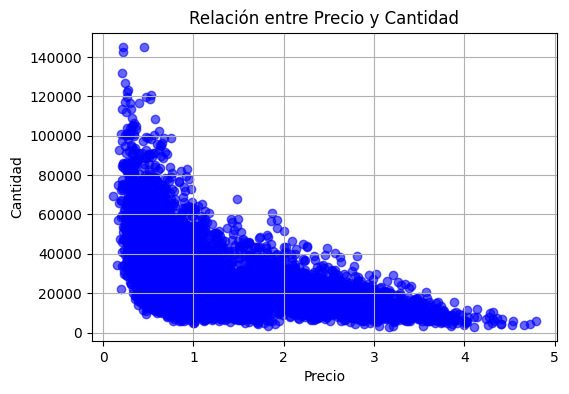

In [14]:
# 0. Graficar relaci√≥n:

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(df["price"], df["quantity"], color="blue", alpha=0.6)
plt.title("Relaci√≥n entre Precio y Cantidad")
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.grid(True)
plt.show()

In [15]:
# 1. Entrenamiento con relaci√≥n mon√≥tona

feature_names = preprocessor.get_feature_names_out()

# crear relaciones:
monotonic_constraints = []
for name in feature_names:
    if "price" in name:
        monotonic_constraints.append(-1)
    else:
        monotonic_constraints.append(0)

monotonic_constraints = tuple(monotonic_constraints)

# definici√≥n de pipeline:
constrained_pipeline = Pipeline([
    ("date_features", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(monotone_constraints=monotonic_constraints, random_state=rs))
])

constrained_pipeline.fit(X_train, y_train)

Pipeline(steps=[('date_features',
                 FunctionTransformer(func=<function extract_date_features at 0x122766f20>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'capacity',
                                                   'day', 'month', 'year']),
                                                 ('num', 'passthrough',
                                                  ['lat', 'long', 'pop',
                                                   'price'])])),
                ('regres...
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=(0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, ...),
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [16]:
# 2. medir mae en conjunto validaci√≥n
y_pred2 = constrained_pipeline.predict(X_val)
mae_constrained = mean_absolute_error(y_val, y_pred2)
print(f"MAE con restricci√≥n mon√≥tona: {mae_constrained:.2f}")

MAE con restricci√≥n mon√≥tona: 2528.49


In [17]:
# 3. Comparar con modelo anterior:
print(f"Mae sin restricci√≥n:{mae_xgb}")
print(f"Mae con restricci√≥n: {mae_constrained}")
print(f"Diferencia: {mae_constrained - mae_xgb}")

Mae sin restricci√≥n:2399.620361328125
Mae con restricci√≥n: 2528.4853515625
Diferencia: 128.864990234375


Notamos que el error aumenta levemente al aplicar la relaci√≥n. El amigo claramente tiene raz√≥n al decir que la demanda disminuye al aumentar el precio (gr√°fico parte 0), sin embargo, al forzarlo en el modelo este parece no aprender m√°s. Esto se puede deber a que la restricci√≥n limita al modelo a aprender patrones m√°s complejos o bien que el precio no tiene mucha influencia.

In [18]:
# 4. guardar modelo
joblib.dump(constrained_pipeline, "constrained_model.pkl")

['constrained_model.pkl']

## 3 Optimizaci√≥n de Hiperpar√°metros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun m√°s* su modelo. En particular, le comenta de la optimizaci√≥n de hiperpar√°metros con metodolog√≠as bayesianas a trav√©s del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuraci√≥n obtenida en la secci√≥n anterior, utilice `optuna` para optimizar sus hiperpar√°metros. En particular, se pide que su optimizaci√≥n considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como m√©todo de muestreo
- De `XGBRegressor`, optimice los siguientes hiperpar√°metros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperpar√°metro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una funci√≥n `objective()` que permita minimizar el `MAE` en el conjunto de validaci√≥n. Use el m√©todo `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el n√∫mero de *trials*, el `MAE` y los mejores hiperpar√°metros encontrados. ¬øC√≥mo cambian sus resultados con respecto a la secci√≥n anterior? ¬øA qu√© se puede deber esto? [3 puntos]
4. Explique cada hiperpar√°metro y su rol en el modelo. ¬øHacen sentido los rangos de optimizaci√≥n indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [19]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 1. Implementar funci√≥n objective
def objective(trial):
    # Hiperpar√°metros:
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    min_frequency = trial.suggest_float("min_frequency", 0.0, 1.0)

    # Preprocesamiento
    onehot_encoder = OneHotEncoder(min_frequency=min_frequency, sparse_output=False, handle_unknown='ignore')

    updated_preprocessor = ColumnTransformer([
        ("cat", onehot_encoder, categorical_cols),
        ("num", "passthrough", numerical_cols)
    ])

    model = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=rs,
        n_jobs=-1
    )

    pipe = Pipeline([
        ("date_features", date_transformer),
        ("preprocessor", updated_preprocessor),
        ("regressor", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    trial.set_user_attr("model", pipe)
    return mae

/Users/vicenteonetto/Desktop/FCFM/11o semestre/ProgramacioÃÅn CientiÃÅfica para Ciencias de Datos/Lab 6 - Optimizacion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# 2-3. Fijar tiempo de entrenamiento y optimizar
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=rs))
study.optimize(objective, timeout=300)

best_trial = study.best_trial
print(f"Trials: {len(study.trials)}")
print(f"Mejor MAE: {best_trial.value:.4f}")
print("Mejores hiperpar√°metros:")
for k, v in best_trial.params.items():
    print(f"  {k}: {v}")

Trials: 152
Mejor MAE: 1952.5050
Mejores hiperpar√°metros:
  learning_rate: 0.07355634007023468
  n_estimators: 874
  max_depth: 10
  max_leaves: 67
  min_child_weight: 4
  reg_alpha: 0.8471610539145066
  reg_lambda: 0.007226064052913079
  min_frequency: 0.00612515932188773


3. Tras optimizar, se obtiene un modelo con un menor valor de MAE de 1953.5 (447 menos que el baseline). La raz√≥n detr√°s es que Optuna permite elegir los mejores hiperpar√°metros para minimizar el MAE, naturalmente haciendolo un mejor modelo.

4. Explicaci√≥n de hiperpar√°metros:

- **learning_rate (0.001, 0.1)**: Controla la velocidad de aprendizaje del modelo. Cuanto menor, m√°s lento pero preciso el ajuste. Se utiliza un rango conservador t√≠pico para evitar sobreajuste.

- **n_estimators (50, 1000)**: N√∫mero de √°rboles (boosting rounds) que utiliza el modelo. M√°s √°rboles pueden capturar mejor patrones, pero tambi√©n tardan m√°s. Tiene un rango razonable que cubre modelos r√°pidos y modelos m√°s complejos.

- **max_depth (3, 10)**: Indica la profundidad m√°xima de cada √°rbol. M√°s profundidad implica m√°s complejidad. El rango de 3 a 10 entrega un buen compromiso entre underfitting y overfitting, pero se podria explorar un modelo m√°s complejo.

- **max_leaves (0, 100)**: Se refiere al n√∫mero m√°ximo de hojas en los √°rboles del modelo. El rango es curioso, pues un numero m√°ximo de 0 hojas haria un modelo vacio, sin embargo, tiene sentido que lo limite hasta 100 para no hacer un modelo demasiado complejo.

- **min_child_weight (1, 5)**: Este par√°metro indica la m√≠nima suma de pesos de observaciones necesarias para dividir un nodo. Un valor m√°s alto indica un modelo m√°s conservador. El rango de 1 a 5 permite evitar splits por ruido, pero se podrian probar para valores m√°s alto dado que optuna sugiere el valor m√°s alto.

- **reg_alpha (0, 1)**: Este par√°metro penaliza por L1 (sparse weights). Tiene un rango que ayuda a regularizaci√≥n y a reducir overfitting en el modelo.

- **reg_lambda (0, 1)**: Similar al anterior, pero penaliza por L2. Ayuda a controlar la magnitud de los coeficientes. El rango tiene sentido, pero se podrian explorar valores mayores.

- **min_frequency (0, 1)**: Usado para el one hot encoder, computa la minima frecuencia en el dataset que debe tener una categoria para ser considerada. El rango cubre todas las posibilidades por lo que tiene sentido.

In [21]:
# 5. Guardar el modelo

import pickle
with open("modelo_optuna.pkl", "wb") as f:
    pickle.dump(best_trial.user_attrs["model"], f)

## 4. Optimizaci√≥n de Hiperpar√°metros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Despu√©s de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en s√≠ mismo. Despu√©s de leer un par de post de personas de dudosa reputaci√≥n en la *deepweb*, usted llega a la conclusi√≥n que puede cumplir este objetivo mediante la implementaci√≥n de **Prunning**.

Vuelva a optimizar los mismos hiperpar√°metros que la secci√≥n pasada, pero esta vez utilizando **Prunning** en la optimizaci√≥n. En particular, usted debe:

- Responder: ¬øQu√© es prunning? ¬øDe qu√© forma deber√≠a impactar en el entrenamiento? [2 puntos]
- Redefinir la funci√≥n `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como m√©todo de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el n√∫mero de *trials*, el `MAE` y los mejores hiperpar√°metros encontrados. ¬øC√≥mo cambian sus resultados con respecto a la secci√≥n anterior? ¬øA qu√© se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opci√≥n anterior, pueden especificar `show_progress_bar = True` en el m√©todo `optimize` para *m√°s sabor*.

Hint: Si quieren especificar par√°metros del m√©todo .fit() del modelo a trav√©s del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementaci√≥n

### Respuesta ¬øQu√© es prunning? ¬øDe qu√© forma deber√≠a impactar en el entrenamiento?

Prunning en el contexto de la optmizicaci√≥n de hiperpar√°metros es un mecanismo para interrumpir tempranamente las b√∫squedas de hiperpar√°metros que muestran un desempe√±o mucho menos "prometedor" que el resto. El objetivo es ahorrar tiempo y recursos computacionales. Esto debiese impactar dr√°sticamente en el tiempo total de la optimizaci√≥n, al concentrar los c√≥mputos en las b√∫squedas m√°s prometedoras. En Optuna, para XGBoost se suele usar XGBoostPruningCallback


In [22]:
%pip install --upgrade xgboost optuna
%pip install "optuna-integration[xgboost]"



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

# comprobamos que nuestras listas est√©n bien
print("Columnas de X_train:", X_train.columns.tolist())
print("Categorical cols:", categorical_cols)
print("Numerical cols:", numerical_cols)

# 1) Creamos el Study con pruner
study_prune = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=rs),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

# 2) Definimos la funci√≥n objective 
def objective_prune(trial):
    
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "seed": rs,
        "verbosity": 0,
    }
    n_rounds = trial.suggest_int("n_estimators", 50, 1000)

    # 2) Reconstruimos el preprocesador con el OneHotEncoder 
    min_freq = trial.suggest_float("min_frequency", 0.0, 1.0)
    ohe = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False,
        min_frequency=min_freq
    )
    preproc = ColumnTransformer([
        ("cat", ohe, categorical_cols),
        ("num", "passthrough", numerical_cols)
    ]).set_output(transform="pandas")

    
    # Primero aplico el transformer de fecha
    Xdt_tr = date_transformer.transform(X_train)
    Xdt_vl = date_transformer.transform(X_val)

    # Luego ajusto y transformo con el preprocesador
    Xtr = preproc.fit_transform(Xdt_tr)
    Xvl = preproc.transform(Xdt_vl)

   
    dtrain = xgb.DMatrix(Xtr, label=y_train)
    dvalid = xgb.DMatrix(Xvl, label=y_val)

    # 5) Callback de pruning
    pruning_cb = XGBoostPruningCallback(trial, "validation-mae")

    # 6) Entreno con xgb.train
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_rounds,
        evals=[(dvalid, "validation")],
        callbacks=[pruning_cb],
        verbose_eval=False
    )

    # 7) Predicci√≥n y c√°lculo de MAE
    preds = booster.predict(dvalid)
    mae = mean_absolute_error(y_val, preds)

    # 8) Guardamos el preprocesador y el booster
    trial.set_user_attr("model", (preproc, booster))
    return mae


# 3) Ejecutamos la optimizaci√≥n (5 minutos)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_prune.optimize(objective_prune, timeout=300, show_progress_bar=True)

# 4) Reportamos resultados
best = study_prune.best_trial
print(f"\n‚Üí Trials completados: {len(study_prune.trials)}")
print(f"‚Üí Mejor MAE con pruning: {best.value:.2f}")
print("‚Üí Hiperpar√°metros √≥ptimos:")
for k, v in best.params.items():
    print(f"   ‚Ä¢ {k}: {v}")

# 5) Guardamos el mejor modelo
import joblib
# para recuperar usamos preproc, booster = best.user_attrs["model"]
joblib.dump(best.user_attrs["model"], "pruned_model.pkl")



Columnas de X_train: ['date', 'city', 'lat', 'long', 'pop', 'shop', 'brand', 'container', 'capacity', 'price']
Categorical cols: ['city', 'shop', 'brand', 'container', 'capacity', 'day', 'month', 'year']
Numerical cols: ['lat', 'long', 'pop', 'price']


Best trial: 92. Best value: 1900.94:  100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 05:00/05:00



‚Üí Trials completados: 932
‚Üí Mejor MAE con pruning: 1900.94
‚Üí Hiperpar√°metros √≥ptimos:
   ‚Ä¢ learning_rate: 0.09805582238908601
   ‚Ä¢ max_depth: 10
   ‚Ä¢ max_leaves: 100
   ‚Ä¢ min_child_weight: 3
   ‚Ä¢ reg_alpha: 0.6575768332950425
   ‚Ä¢ reg_lambda: 0.9864590628250672
   ‚Ä¢ n_estimators: 658
   ‚Ä¢ min_frequency: 0.03033638055122641


['pruned_model.pkl']

Notemos que para el n√∫mero de trials:

- Sin pruning (secci√≥n 3): 152¬†trials en 5‚ÄØmin.

- Con pruning (secci√≥n 4.2):¬†957¬†trials en 5‚ÄØmin.

Explicaci√≥n: el pruning aborta muy pronto los ensayos que no prometen (descarte temprano), por lo que en el mismo tiempo permitimos evaluar muchas m√°s combinaciones.

Mejor MAE obtenido:
 
- Sin pruning: MAE¬†‚âà¬†1952.51
- Con pruning: MAE¬†‚âà¬†1900.94

Logramos reducir el error en validaci√≥n en unos 51 puntos gracias a explorar m√°s configuraciones √∫tiles.

Hiperpar√°metros:

| Par√°metro            | Sin pruning | Con pruning |
| -------------------- | ----------- | ----------- |
| learning\_rate       | 0.0736      | 0.0981      |
| n\_estimators        | 874         | 658         |
| max\_depth           | 10          | 10          |
| max\_leaves          | 67          | 100         |
| min\_child\_weight   | 4           | 3           |
| reg\_alpha           | 0.8472      | 0.6576      |
| reg\_lambda          | 0.0072      | 0.9865      |
| min\_frequency (OHE) | 0.0061      | 0.0303      |



El pruning no solo acelera la b√∫squeda de buenas configuraciones, sino que, en el mismo tiempo, tambi√©n mejora el rendimiento final del modelo.


## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gr√°fico de historial de optimizaci√≥n [1 punto]
2. Gr√°fico de coordenadas paralelas [1 punto]
3. Gr√°fico de importancia de hiperpar√°metros [1 punto]

Comente sus resultados:

4. ¬øDesde qu√© *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¬øQu√© tendencias puede observar a partir del gr√°fico de coordenadas paralelas? [1 punto]
6. ¬øCu√°les son los hiperpar√°metros con mayor importancia para la optimizaci√≥n de su modelo? [0.5 puntos]

In [26]:


from optuna.visualization import (
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances,
)

# ‚Äî‚Äî‚Äî‚Äî‚Äî Visualizaciones SIN Pruning ‚Äî‚Äî‚Äî‚Äî‚Äî
# 1. Historial de optimizaci√≥n sin pruning
fig1 = plot_optimization_history(study)
fig1.update_layout(title="Optimization History (sin pruning)")
fig1.show()

# 2. Coordenadas paralelas sin pruning
fig2 = plot_parallel_coordinate(study)
fig2.update_layout(title="Parallel Coordinate (sin pruning)")
fig2.show()

# 3. Importancia de hiperpar√°metros sin pruning
fig3 = plot_param_importances(study)
fig3.update_layout(title="Param Importances (sin pruning)")
fig3.show()


# ‚Äî‚Äî‚Äî‚Äî‚Äî Visualizaciones CON Pruning ‚Äî‚Äî‚Äî‚Äî‚Äî
# 1. Historial de optimizaci√≥n con pruning
fig4 = plot_optimization_history(study_prune)
fig4.update_layout(title="Optimization History (con pruning)")
fig4.show()

# 2. Coordenadas paralelas con pruning
fig5 = plot_parallel_coordinate(study_prune)
fig5.update_layout(title="Parallel Coordinate (con pruning)")
fig5.show()

# 3. Importancia de hiperpar√°metros con pruning
fig6 = plot_param_importances(study_prune)
fig6.update_layout(title="Param Importances (con pruning)")
fig6.show()


#### 5.4) ¬øDesde qu√© trial se empiezan a observar mejoras notables?

* **Sin pruning** (primer gr√°fico):

  * El MAE arranca alrededor de 9‚ÄØ600 en el **trial‚ÄØ1**.
  * Hay un descenso r√°pido hasta unos 5‚ÄØ700‚Äì7‚ÄØ300 entre los **trials‚ÄØ2 y‚ÄØ6**.
  * **La gran ca√≠da al entorno de 2‚ÄØ000** se alcanza **alrededor del trial‚ÄØ10**. A partir de ah√≠, el ‚Äúbest value‚Äù (l√≠nea roja) se mantiene muy estable y las mejoras son marginales.

* **Con pruning** (cuarto gr√°fico):

  * Arrancamos cerca de 9‚ÄØ000 en el trial‚ÄØ1.
  * Bajamos a \~5‚ÄØ700 ya en el **trial‚ÄØ3**.
  * Y **alcanzamos valores pr√≥ximos a 2‚ÄØ000** en torno al **trial‚ÄØ7 u‚ÄØ8**, qued√°ndonos muy cerca del m√≠nimo final desde entonces.

**Conclusi√≥n 5.4:**

* Sin pruning las ca√≠das m√°s significativas se ven hasta el trial‚ÄØ10.
* Con pruning, el modelo ‚Äúaprende‚Äù lo esencial ya en el trial‚ÄØ7‚Äì8 gracias a la poda temprana de configuraciones poco prometedoras.

---

#### 5.5 ¬øQu√© tendencias se observan en los gr√°ficos de coordenadas paralelas?

En ambos casos las l√≠neas de color m√°s intenso (menor MAE) **convergen en regiones concretas** de cada eje:

1. **learning\_rate**:

   * Sin pruning: las mejores configuraciones suelen estar en el rango medio‚Äëalto (\~0.05‚Äì0.10).
   * Con pruning: aun m√°s concentrado entre \~0.07‚Äì0.10.

2. **max\_depth**:

   * Casi siempre vale **10** ‚Äî todos los trials con error m√≠nimo usan la profundidad m√°xima.

3. **max\_leaves**:

   * Baja dispersi√≥n: las l√≠neas ‚Äúazul oscuro‚Äù (buenos MAE) se agrupan hacia valores altos de hojas (‚âà60‚Äì100).

4. **min\_child\_weight**:

   * Se observa que valores de **3 a 5** producen sistem√°ticamente mejor MAE.

5. **min\_frequency** (frecuencia m√≠nima para OneHotEncoder):

   * Sin pruning: pr√°cticamente toda la mejora viene de hacer min_frequency muy bajo (<0.02)
   * Con pruning: sigue baja, pero con m√°s variabilidad (0.001‚Äì0.03) y combinada con otros par√°metros.

6. **n\_estimators**:

   * Sin pruning: alrededor de \~900.
   * Con pruning: un poco m√°s bajo (700), pero tambi√©n con cierta flexibilidad entre 400 - 700.

7. **reg\_alpha / reg\_lambda**:

   * Sin pruning: el L1 (reg_alpha) tiene algo de efecto, aunque menor.
   * Con pruning: las l√≠neas de menor MAE aparecen con **reg\_lambda altas** (‚âà0.9)

   ---

#### 5.6 ¬øQu√© hiperpar√°metros tienen mayor importancia?

Del gr√°fico de importancias:

* **Sin pruning**:

  1. **min\_frequency** domina con \~93‚ÄØ% de importancia.
  2. Luego muy por detr√°s `reg_alpha` (\~3‚ÄØ%), `n_estimators` (\~2‚ÄØ%) y restos (<1‚ÄØ%).

* **Con pruning**:

  1. **reg\_lambda** es el rey (\~36‚ÄØ%).
  2. Le siguen **learning\_rate** (\~30‚ÄØ%) y **min\_frequency** (\~28‚ÄØ%).
  3. Ya en tercera l√≠nea aparece `max_leaves` (\~4‚ÄØ%), con `n_estimators`, `reg_alpha`, `max_depth` y `min_child_weight` pr√°cticamente irrelevantes.



 Cuando no pod√°bamos, la frecuencia m√≠nima de las categor√≠as era lo que de verdad mov√≠a el MAE.
 Al podar, liberar el espacio de b√∫squeda permite que la **regularizaci√≥n L2** (`reg_lambda`) y la **tasa de aprendizaje** cobren protagonismo: el modelo ajusta mejor sus pesos y aprende m√°s r√°pido, mientras que `min_frequency` sigue siendo clave para no inflar el n√∫mero de variables dummies.

## 6. S√≠ntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validaci√≥n obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¬øqu√© modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¬øExisten diferencias con respecto a las m√©tricas obtenidas en el conjunto de validaci√≥n? ¬øPorqu√© puede ocurrir esto? [1 punto]

#### 6.1

| Modelo                                   | MAE (Aprox) |
| :--------------------------------------- | ---------------: |
| 1) Baseline ‚Äì DummyRegressor             |         13‚ÄØ544.2 |
| 2) XGBRegressor (default)                |          2‚ÄØ400.1 |
| 3) XGBRegressor con monotonic constraint |          2‚ÄØ480.3 |
| 4) XGB+Optuna (sin pruning)              |          1‚ÄØ952.5 |
| 5) XGB+Optuna (con pruning)              |          1‚ÄØ900.9 |

---

#### 6.2

Claramente el modelo optimizado con Optuna **y** prunning (modelo‚ÄØ5) obtiene el MAE m√°s bajo (‚âà‚ÄØ1‚ÄØ900). Esto muestra el beneficio de combinar b√∫squeda bayesiana y poda temprana de configuraciones poco prometedoras.



In [32]:
import joblib
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

loaded = joblib.load("pruned_model.pkl")
print(type(loaded))

if isinstance(loaded, tuple):
    print("Tupla de longitud:", len(loaded))
    for i, v in enumerate(loaded):
        print(i, type(v))



# 1) Cargar transformer y booster
ct, booster = joblib.load("pruned_model.pkl")

# 2) Define la funci√≥n para extraer las fechas
def extract_date_features(X):
    X = X.copy()
    X["year"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.year.astype("category")
    X["month"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.month.astype("category")
    X["day"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.day.astype("category")
    return X.drop(columns="date")

from sklearn.preprocessing import FunctionTransformer
date_transformer = FunctionTransformer(extract_date_features)

# 3) Aplica primero el extractor de fecha
X_test_dt = date_transformer.transform(X_test)

# 4) Luego transforma con el ColumnTransformer
#    
X_test_proc = ct.transform(X_test_dt)

# 5) Crea el DMatrix para XGBoost
dtest = xgb.DMatrix(X_test_proc)

# 6) Predice con el booster
y_pred_test = booster.predict(dtest)

# 7) Calcula el MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"MAE en test: {mae_test:.2f}")



<class 'tuple'>
Tupla de longitud: 2
0 <class 'sklearn.compose._column_transformer.ColumnTransformer'>
1 <class 'xgboost.core.Booster'>
MAE en test: 1871.28


#### 6.3
Notemos que obtuvimos un MAE en el test de aprox. 1871

#### 6.4

El MAE en test (1‚ÄØ871) es ligeramente mejor que el de validaci√≥n (1‚ÄØ900).

Razones posibles:

Variabilidad de la muestra: Validaci√≥n y test son subconjuntos distintos; pueden diferir un poco en su dificultad.

Peque√±a sobreoptimizaci√≥n en validaci√≥n: al iterar tanto sobre esa partici√≥n, el modelo ‚Äúse adapt√≥‚Äù un poco m√°s a ella.

Azar estad√≠stico: incluso con semillas fijas, la distribuci√≥n de errores puede variar.

# Conclusi√≥n
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://i.pinimg.com/originals/55/3d/42/553d42bea9b10e0662a05aa8726fc7f4.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>